# This notebooks shows the backtest of clusters using Quality, Volatility, and Value

In [1]:
import numpy as np
import pandas as pd
import norgatedata 
import datetime
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

[2020-10-31 19:49:33.110458] WARNING: Norgate Data: **PACKAGE VERSION WARNING*** You have version (1.0.31) of the norgatedata package installed.  A newer version 1.0.52 is available and is a recommended upgraded.
[2020-10-31 19:49:33.112452] INFO: Norgate Data: NorgateData package v1.0.31: Init complete


In [2]:
path = 'D:/Udacity/final/'

import clstr timeseries and prices

In [4]:
clstr_td_ct = pickle.load(open(path + 'qvv_clstr_ts_f.pkl','rb'))

Import prices

In [5]:
russell_prices = pd.read_csv(path + 'russell_prices_pre_f.csv',parse_dates=True,index_col = 0)

constructing daily returns, need to ffill for handling data purposes. So that it can be a return of 0 even though we don't have price data for it. We might invest on rebalance day and we're suppose to invest for a month, but then a symbol gets delisted bewtween the month. FFill() will handle this in that after it gets delisted we have zero return. 

In [6]:
return_series = russell_prices.ffill()/russell_prices.ffill().shift(1) - 1

We want to start on rebalance day

In [7]:
return_series = return_series.loc['2003-01-31':]

Forming our backtest return seris by multiplying with constituent series

In [8]:
backtest_clstr_series = {}

for k,df in clstr_td_ct.items():
    # shift constiteunts since we avoid look forward bias, we will get signal on rebalance day, and then 
    # invest on next day close, which means the returns will be calculated the next nextday of our invest day
    temp_df  = (return_series * df.loc['2003-01-31':].shift(2)).fillna(0)
    #find total return by taking sum
    temp_df['tot_ret'] = temp_df.sum(axis=1)
    #find total assets at those observations (notice shift 2 for consistency)
    temp_df['n_assets'] = df.sum(axis=1).reindex(temp_df.index).shift(2)
    #find real returns by dividing total return by number of assets (equally invested)
    temp_df['w_ret'] = temp_df['tot_ret'] / temp_df['n_assets']
    
    temp_df['port'] = (temp_df['w_ret'] + 1).cumprod() * 10000
    #fill na with 10000 for the first two rows
    temp_df['port'].fillna(10000,inplace=True)
    
    backtest_clstr_series[k] = temp_df

In [9]:
def get_years_past(series: pd.Series):
    """
    Computes how many years between start and end 
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float in years
    """
    
    start_date = series.index[0]
    end_date = series.index[-1]
    return (end_date - start_date).days / 365.25
 
def calculate_cagr(series: pd.Series):
    """
    Computes cumulative annual growth rate
   
    Parameters
    ----------
    series: Series
        Time Series
    Returns
    -------
    float 
    """
    
    start_price = series.iloc[0]
    end_price = series.iloc[-1]
    value_factor = end_price / start_price
    year_past = get_years_past(series)
    return (value_factor ** (1 / year_past)) - 1

def calculate_log_return_series(series: pd.Series):
    """
    Computes log daily returns
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    shifted_series = series.shift(1, axis=0)
    return pd.Series(np.log(series / shifted_series))
 
def calculate_annualized_volatility(series: pd.Series):
    """
    Computes annualized volatility
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    years_past = get_years_past(series)
    return_series = calculate_log_return_series(series)
    entries_per_year = return_series.shape[0] / years_past
    return return_series.std() * np.sqrt(entries_per_year)

def calculate_maxdd(series: pd.Series):
    """
    Computes maximum drawdown
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    port = series.copy()
    running_max = np.maximum.accumulate(port)

    #Ensure the value never drops below 1
    running_max[running_max<1] = 1
    
    #Calculate the percentage drawdown
    drawdown = (port)/running_max - 1
    
    #Plot results
    return drawdown.min()

def calculate_cum_return(series: pd.Series):
    """
    Computes cumulative return
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    start_price = series.iloc[0]
    end_price = series.iloc[-1]
    
    return end_price/start_price - 1

def calculate_sr(return_series: pd.Series):
    """
    Computes Sharpe Ratio
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    Sharpe_Ratio = return_series.mean() / return_series.std()
    
    return (252 ** 0.5) * Sharpe_Ratio

def plot_drawdown(port_value,label=None):
    """
    Plots the drawdown 
   
    Parameters
    ----------
    port_value: Series
        Time series indicating our portfolio value
    label: str
        Label of plot 
    """
    
    port = port_value.copy()
    running_max = np.maximum.accumulate(port)

    #Ensure the value never drops below 1
    running_max[running_max<1] = 1
    
    #Calculate the percentage drawdown
    drawdown = (port)/running_max - 1
    
    #Plot results
    drawdown.plot(label=label)
    

Backtest Performance

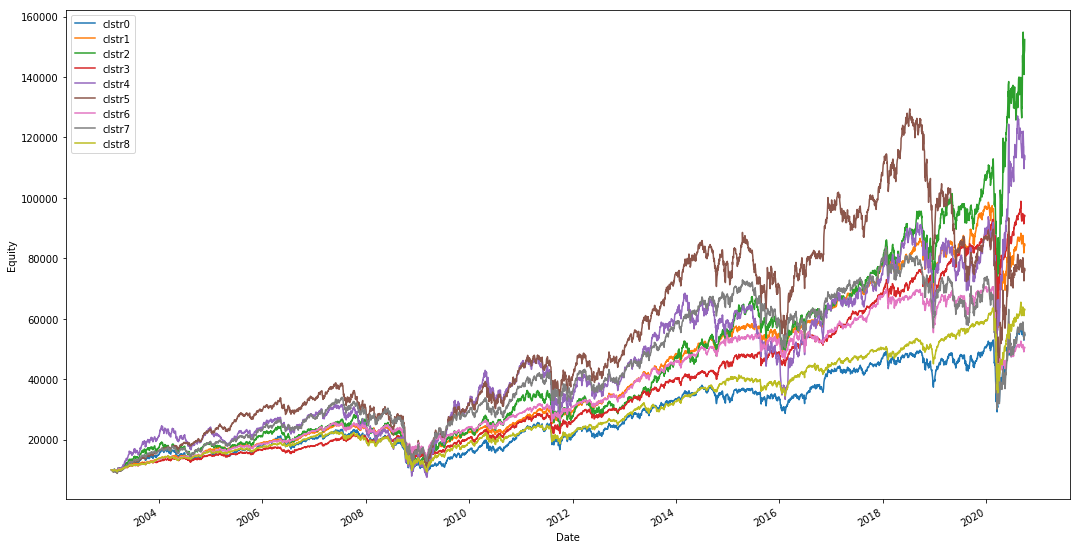

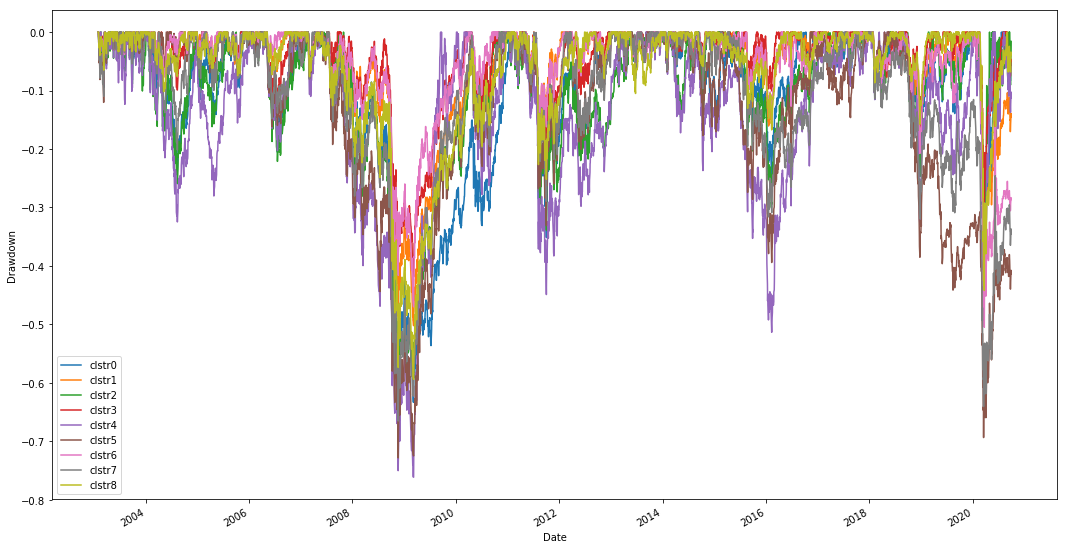

In [16]:
plt.figure(figsize=(18,10))
for k,df in backtest_clstr_series.items():
    df['port'].plot(label='clstr' + str(k))

plt.legend()
plt.ylabel('Equity')
plt.figure(figsize=(18,10))


for k,df in backtest_clstr_series.items():
    plot_drawdown(df['port'].dropna(),label = 'clstr' + str(k))
    
plt.legend()
plt.ylabel('Drawdown')
plt.show()

metric_list = []
c_index = []
metric_columns = ['CAGR','Annual Vol','MaxDD','Cum Returns','Sharp Ratio']
for k,df in backtest_clstr_series.items():
    temp_list = []
    temp_list.append(calculate_cagr(df['port']))
    temp_list.append(calculate_annualized_volatility(df['port']))
    temp_list.append(calculate_maxdd(df['port']))
    temp_list.append(calculate_cum_return(df['port']))
    temp_list.append(calculate_sr(df['w_ret']))
    
    metric_list.append(temp_list)
    
    c_index.append('Cluster ' + str(k))
    
    
metric_np = np.asarray(metric_list)

metric_df = pd.DataFrame(data=metric_np,index=c_index,columns=metric_columns)


In [11]:
metric_df

,CAGR,Annual Vol,MaxDD,Cum Returns,Sharp Ratio
Cluster 0,0.100678,0.266747,-0.633272,4.442542,0.494242
Cluster 1,0.128240,0.184905,-0.502153,7.423829,0.748317
Cluster 2,0.166742,0.284003,-0.648588,14.237101,0.686077
Cluster 3,0.135287,0.177643,-0.418390,8.403094,0.805304
Cluster 4,0.146993,0.350232,-0.761316,10.270884,0.568020
Cluster 5,0.121644,0.323109,-0.728329,6.595062,0.518460
Cluster 6,0.095895,0.200962,-0.504792,4.039591,0.559585
Cluster 7,0.101014,0.283939,-0.665238,4.471927,0.482604
Cluster 8,0.109790,0.220093,-0.593879,5.295606,0.586959


In [90]:
path = 'D:/Udacity/'

In [91]:
metric_df.to_csv(path + 'qvv_backtest_metrics.csv')